# MODEL YANG DIPAKAI:
- **ARIMA** dan **LSTM**, keduanya punya tujuan yang sama, yakni memprediksi nilai masa depan berdasarkan data historis. ARIMA bekerja dengan asumsi hubungan linear dan stasioneritas. Sedangkan LSTM (Long Short-Term Memory) adalah tipe Recurrent Neural Network (RNN) yang mampu menangkap pola non-linear dan ketergantungan jangka panjang (long-term dependencies) yang sering diabaikan ARIMA.

## Import all libraries needed

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Load data asli (9 kolom: Index, Date, Open, High, Low, Close, Adj Close, Volume, CloseUSD)
df = pd.read_csv('../dataset/indexProcessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Kita pilih Index 'NYA' (New York Stock Exchange) sebagai contoh utama
data = df[df['Index'] == 'NYA'].sort_values('Date').reset_index(drop=True)
data.set_index('Date', inplace=True)

print(f"Dataset dimuat dengan {data.shape[1]} kolom asli.")
data.head()

Dataset dimuat dengan 8 kolom asli.


,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD
Date,,,,,,,,
1965-12-31,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002
1966-01-03,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022
1966-01-04,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027
1966-01-05,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,531.119995
1966-01-06,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,532.070007


## 1. EDA

### Visualisasi 1: Time Series Multi-Line Plot

- **Kegunaan**: Melihat tren harga Close dan Open secara bersamaan untuk mendeteksi fluktuasi.

- **Aesthetics & Mapping**:

- 1. X-axis (Aesthetic: Position): Date (Temporal data).

- 2. Y-axis (Aesthetic: Position): Price (Continuous numerical data).

- 3. Color (Aesthetic: Hue): Variable (Discrete: 'Open' vs 'Close').

- Warna: Menggunakan Double Hue (misal: Biru untuk Close, Oranye untuk Open). Warna diskrit dipilih untuk membedakan dua entitas harga yang berbeda namun berada di skala yang sama.

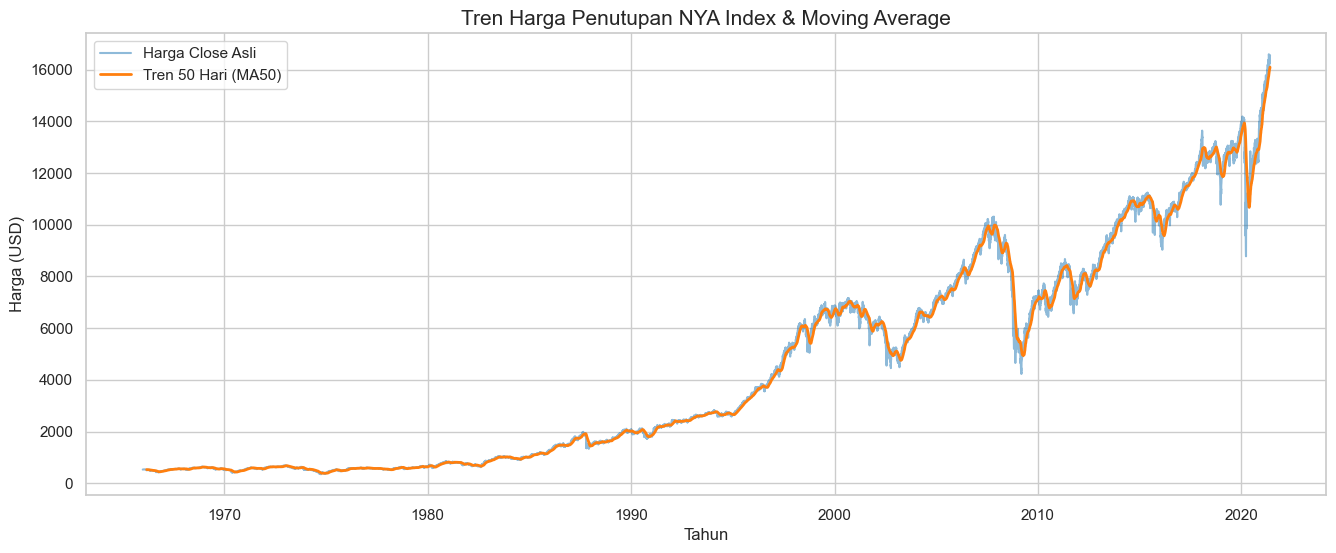

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(data['Close'], label='Harga Close Asli', color='#1f77b4', alpha=0.5)
plt.plot(data['Close'].rolling(window=50).mean(), label='Tren 50 Hari (MA50)', color='#ff7f0e', linewidth=2)

plt.title('Tren Harga Penutupan NYA Index & Moving Average', fontsize=15)
plt.xlabel('Tahun')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

### Visualisasi 2: Heatmap Korelasi Antar Fitur

- **Kegunaan**: Efektif untuk melihat hubungan antar banyak variabel numerik sekaligus (9 kolom).

- **Aesthetics & Mapping**:

- 1. X & Y Axis: Nama kolom (Kategorikal).

- 2. Color (Intensity): Nilai korelasi -1 sampai 1.

- Warna: Continuous Diverging (Merah-Kuning-Hijau). Hijau menunjukkan korelasi positif kuat, Merah korelasi negatif.

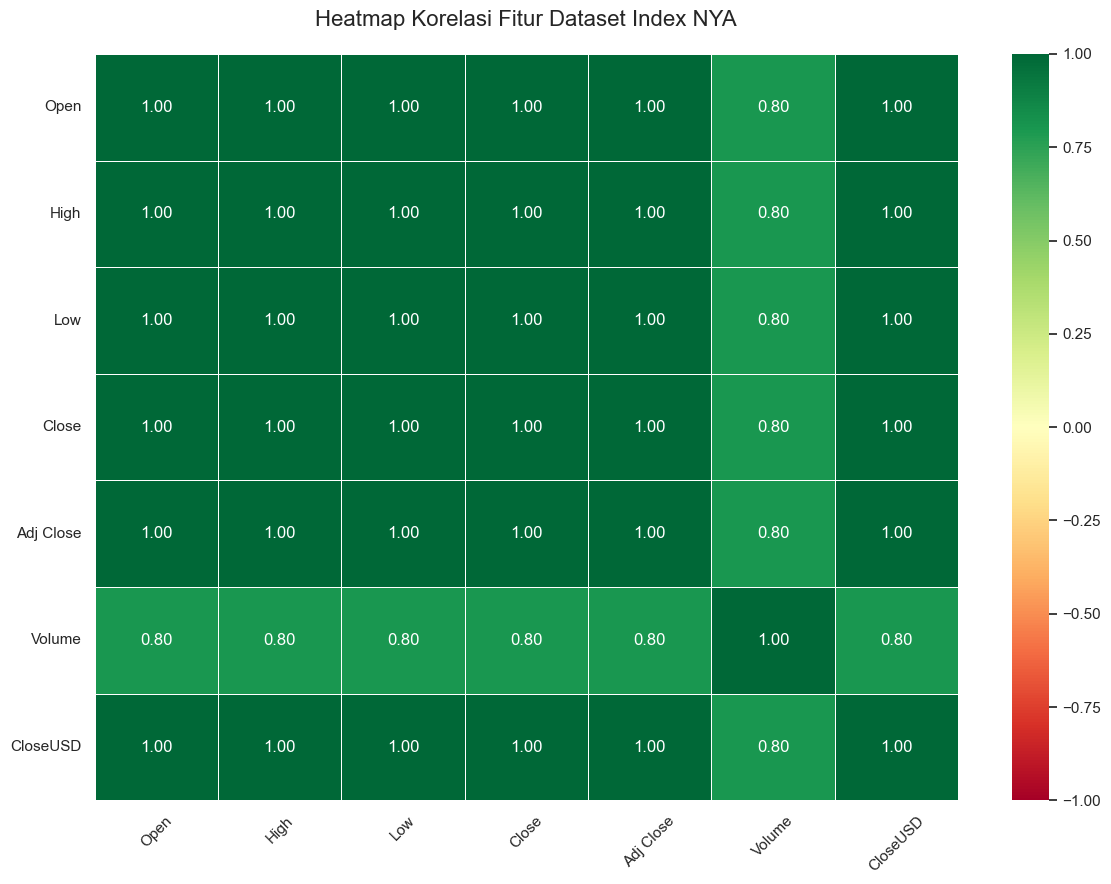

In [ ]:
plt.figure(figsize=(12, 9))

# 1. Menghitung korelasi hanya untuk kolom numerik (9 kolom asli)
# Menghasilkan matriks korelasi Pearson antara -1 hingga 1
corr_matrix = data.corr(numeric_only=True)

# 2. Membuat Heatmap dengan skema warna RdYlGn (Red-Yellow-Green)
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='RdYlGn', 
            center=0, 
            vmin=-1, 
            vmax=1, 
            fmt='.2f', 
            linewidths=0.5)

plt.title('Heatmap Korelasi Fitur Dataset Index NYA', fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Preprocessing

### Data Untuk LSTM

In [24]:
# Ambil kolom Close
dataset = data[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split 80% Train, 20% Test
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Membuat sliding window (misal: 60 hari untuk prediksi hari ke-61)
def create_window(dataset, window=60):
    X, y = [], []
    for i in range(window, len(dataset)):
        X.append(dataset[i-window:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X_train, y_train = create_window(train_data, window_size)
X_test, y_test = create_window(test_data, window_size)

# Reshape untuk LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Training Model

### LSTM (Deep Learning)

In [25]:
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1) # Epochs kecil untuk simulasi

Epoch 1/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0011
Epoch 2/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 2.9498e-04
Epoch 3/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 2.5671e-04
Epoch 4/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 2.5007e-04
Epoch 5/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 2.4603e-04


### ARIMA & Prediksi

In [26]:
# Untuk ARIMA, kita pakai data asli (bukan scaled)
history = [x for x in data['Close'][:train_size]]
test_actual = data['Close'][train_size + window_size:] # Samakan dengan test LSTM
arima_preds = []

print("Memulai Prediksi ARIMA (Baseline)...")
for t in range(len(test_actual)):
    # Simple ARIMA untuk efisiensi di notebook
    model_arima = ARIMA(history[-200:], order=(5,1,0)) # Gunakan 200 data terakhir
    res = model_arima.fit()
    arima_preds.append(res.forecast()[0])
    history.append(test_actual.iloc[t])

Memulai Prediksi ARIMA (Baseline)...


## Model Comparison
Memberikan jawaban visual terkait model mana yang lebih baik.

### Visualiasasi Perbandingan Model

- **Kegunaan**: Line Plot memungkinkan perbandingan tren antara 3 kategori data berbeda di skala waktu yang sama.

- **Aesthetics & Mapping**:

- 1. X-axis: Time (Interval).

- 2. Y-axis: Value (USD).

- 3. Color & Style: Aktual (Hitam/Solid), ARIMA (Biru/Putus-putus), LSTM (Merah/Titik-garis).

- Warna: Menggunakan warna diskrit yang sangat berbeda (Hitam, Biru, Merah) untuk meminimalkan kebingungan pembaca.

86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


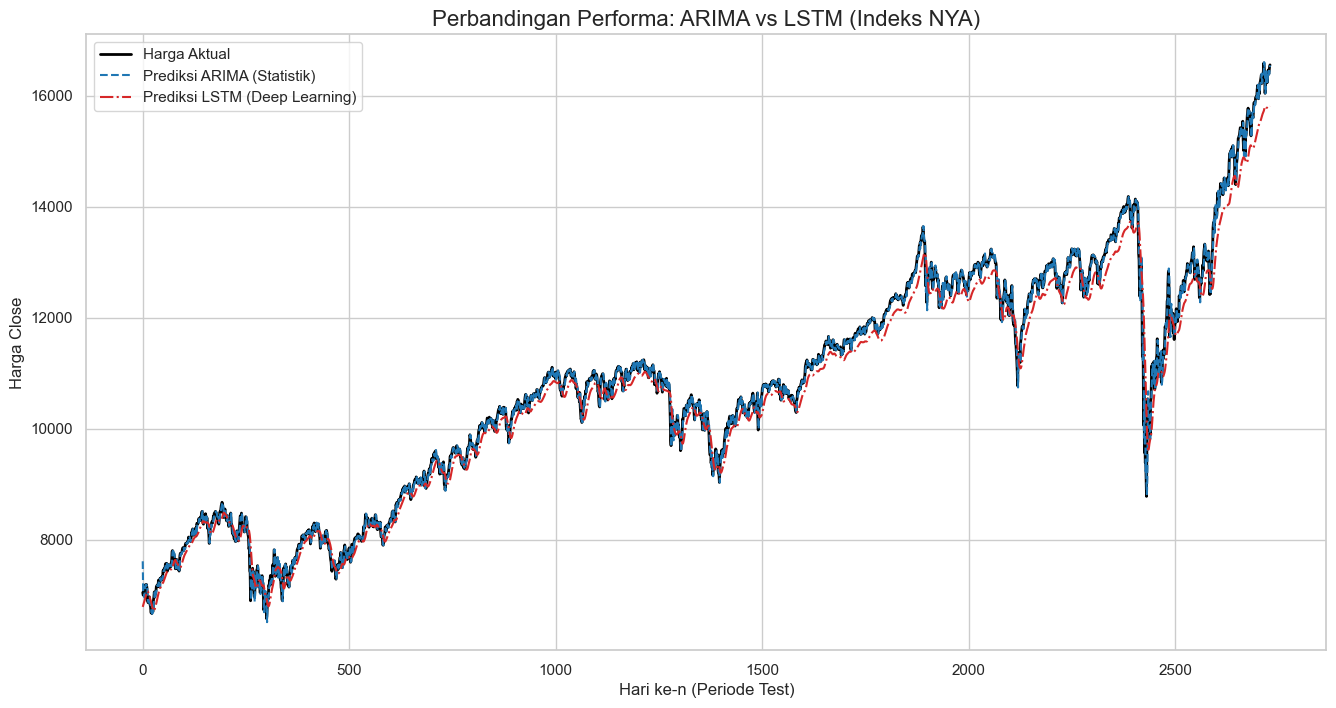

In [27]:
# Prediksi LSTM dan Inverse Transform
lstm_preds = model_lstm.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_preds)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(16, 8))
plt.plot(actual_prices, label='Harga Aktual', color='black', linewidth=2)
plt.plot(arima_preds, label='Prediksi ARIMA (Statistik)', color='#1f77b4', linestyle='--')
plt.plot(lstm_preds, label='Prediksi LSTM (Deep Learning)', color='#d62728', linestyle='-.')

plt.title('Perbandingan Performa: ARIMA vs LSTM (Indeks NYA)', fontsize=16)
plt.xlabel('Hari ke-n (Periode Test)')
plt.ylabel('Harga Close')
plt.legend()
plt.show()

### Visualisasi Metrik Error

- **Kegunaan**: Bar Chart paling baik dalam membandingkan nilai numerik antar kategori (Model).

- **Aesthetics & Mapping**:

- 1. X-axis: Model Name (Kategorikal).

- 2. Y-axis: MAPE Value (Kontinu).

- 3. Color: Konsisten dengan warna di plot sebelumnya (Biru=ARIMA, Merah=LSTM).

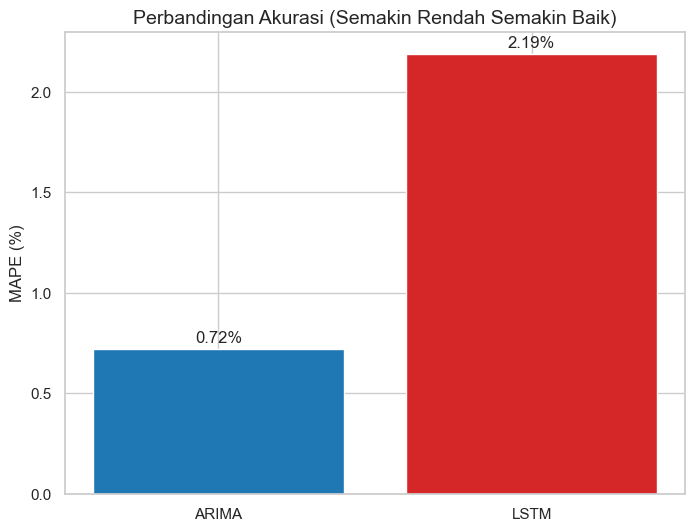

In [33]:
# Hitung MAPE
mape_arima = mean_absolute_percentage_error(actual_prices, arima_preds) * 100
mape_lstm = mean_absolute_percentage_error(actual_prices, lstm_preds) * 100

models = ['ARIMA', 'LSTM']
mape_values = [mape_arima, mape_lstm]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, mape_values, color=['#1f77b4', '#d62728'])
plt.ylabel('MAPE (%)')
plt.title('Perbandingan Akurasi (Semakin Rendah Semakin Baik)', fontsize=14)

# Tambah label angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{round(yval, 2)}%', ha='center')

plt.show()